In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Declare a Base using "automap_base()"
Base = automap_base()

In [7]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Display the row's columns and data in dictionary format (Measurement)
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fee2c592190>,
 'tobs': 65.0,
 'station': 'USC00519397',
 'prcp': 0.08,
 'id': 1,
 'date': '2010-01-01'}

In [12]:
# Inspect data in columns to determine data types
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Find the most recent date in the data set.
engine.execute('SELECT * FROM measurement ORDER BY date DESC LIMIT 10').fetchall()

[(2724, 'USC00519397', '2017-08-23', 0.0, 81.0),
 (7635, 'USC00514830', '2017-08-23', 0.0, 82.0),
 (12187, 'USC00519523', '2017-08-23', 0.08, 82.0),
 (19550, 'USC00516128', '2017-08-23', 0.45, 76.0),
 (2723, 'USC00519397', '2017-08-22', 0.0, 82.0),
 (12186, 'USC00519523', '2017-08-22', 0.0, 82.0),
 (19549, 'USC00516128', '2017-08-22', 0.5, 76.0),
 (2722, 'USC00519397', '2017-08-21', 0.0, 81.0),
 (7634, 'USC00514830', '2017-08-21', 0.02, 79.0),
 (12185, 'USC00519523', '2017-08-21', None, 82.0)]

In [14]:
# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) -  dt.timedelta(days=365)
print(f"One Year Prior: {year_ago}")

One Year Prior: 2016-08-23


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results, starting 
# from the most recent data point in the database. 

# Perform a query to retrieve the data and precipitation measurements
one_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()
#one_year

In [16]:
# Save the query results as a Pandas DataFrame & sort values by date
one_year_df = pd.DataFrame(data=one_year, columns=["date","precipitation"]).sort_values("date")
#one_year_df

In [17]:
# Convert the data type in the date column to datetime, confirm the data type updated
one_year_df["date"] = pd.to_datetime(one_year_df["date"], format="%Y-%m-%d")
one_year_df.dtypes

date             datetime64[ns]
precipitation           float64
dtype: object

In [18]:
# Set the index of the DataFrame to date
one_year_df = one_year_df.set_index("date")
one_year_df

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


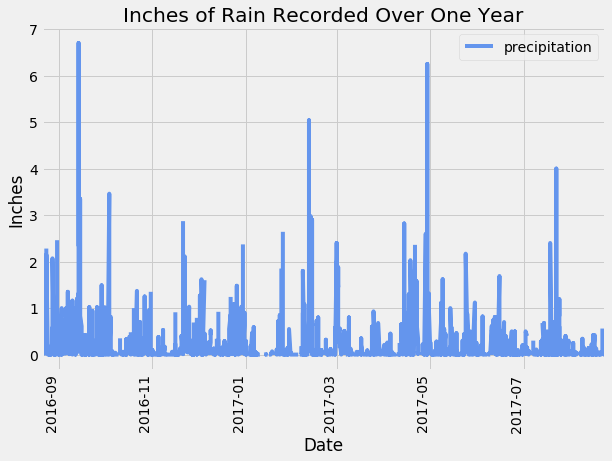

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data
one_year_df.plot(color="cornflowerblue", title="Inches of Rain Recorded Over One Year", rot=90, figsize=(9,7))
plt.xlim(year_ago -  dt.timedelta(days=2), year_ago + dt.timedelta(days=365))
plt.legend(loc="upper right")
plt.ylabel("Inches")
plt.xlabel("Date")
plt.show()

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
one_year_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [21]:
# Display the row's columns and data in dictionary format (Station)
first_row = session.query(Station).filter(Station.station=="USC00519281").first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fee2e1cc710>,
 'id': 7,
 'station': 'USC00519281',
 'latitude': 21.45167,
 'elevation': 32.9,
 'name': 'WAIHEE 837.5, HI US',
 'longitude': -157.84888999999998}

In [22]:
# Design a query to calculate the total number of stations in the dataset
num_station = session.query(Measurement.station).distinct().count()
print(f"There are {num_station} weather stations.") 

There are 9 weather stations.


In [23]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).\
order_by(func.count(Measurement.id).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Create a varaible to use to call back station ID for the most active station.
top_station = most_active[0][0]
# top_station

In [25]:
# Determine number of rows to reconfirm data listed above.
num_rows = session.query(Measurement.id).count()
num_rows

19550

In [26]:
# Query for the station name associated with the most active station
station_name = session.query(Station.name).filter(Station.station == top_station).all()
# station_name

In [27]:
print(f"The most active station is {station_name[0][0]} with {most_active[0][1]} observations.")

The most active station is WAIHEE 837.5, HI US with 2772 observations.


In [28]:
# Using the most active station id from the previous query, calculate the lowest temperature.
low = session.query(func.min(Measurement.tobs)).filter(Measurement.station == top_station).all()
# low

In [29]:
# Using the most active station id from the previous query, calculate the lowest highest temperature.
high = session.query(func.max(Measurement.tobs)).filter(Measurement.station == top_station).all()
# high

In [30]:
# Using the most active station id from the previous query, calculate the lowest average temperature.
avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == top_station).all()
# avg

In [31]:
# Print the results for the most active station.
print(f'''For station "{top_station}" or "{station_name[0][0]}" the:
Minimum Temperature (F) = {low[0][0]},
Maximum Temperature (F) = {high[0][0]}, &
Average Temeperature (f) = {avg[0][0]}''')

For station "USC00519281" or "WAIHEE 837.5, HI US" the:
Minimum Temperature (F) = 54.0,
Maximum Temperature (F) = 85.0, &
Average Temeperature (f) = 71.66378066378067


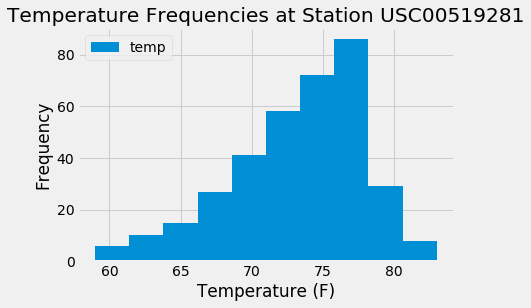

In [32]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Query for the date and tobs and then filter by both station and date range
# Code to query over last 12 months adapted from study group session with Andrew
temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == top_station).\
filter(Measurement.date >= year_ago).all()

# Create a DataFrame from the query data
waihee = pd.DataFrame(data=temp, columns=["date", "temp"])

# Plot the DataFrame into a histogram
waihee.plot(kind="hist")
plt.xlabel("Temperature (F)")
plt.title(f"Temperature Frequencies at Station {top_station}")
plt.show()

# Close session

In [33]:
# Close Session
session.close()